# Projet volatilité stochastique


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.stats import truncnorm  

In [ ]:
class law:
    def normal():
        """
        Tirage selon Box-Muller, renvoie un couple de variable aléatoire indep
        """
        U = np.random.uniform(0,1, 2)
        #return np.sqrt(-2*np.log(U[0]))*np.array([np.cos(2*np.pi*U[1]),np.sin(2*np.pi*U[1])])
        return np.random.normal(0,1, 2)
    
    def inverse_gamma(a,b):
        """
        Tirage selon une inverse gamma ---->>>>>>> fonctionne bien !!!!!!
        """
        return (1/(np.random.gamma(a,1/b)))

    def metro_hasting(Xi,mu,sigma,theta,Y, Xi_1):  ######### IL Y A UN PROBLEME ICI !!!!!!
        """
        Simulation des Xt
        entrée :
            - Xt = le current Xt que l'on compute
            - mu,simga, theta = les paramètres déjà compute
            - Y = toujours le même Y
            - Xt_1 = Xt-1 qui sert pour Xt+1 à chaque fois que l'on souhaite caluculer Xt (Xt+1) est celui de l'itération précédente.
        """
        T = len(Y)-1
        
        ########################## Définition des fonctions du rapport ########################################################
        def pi_eq(x,mu,sigma,theta,y,x0,x2):
            """
            Densité de la loi invariante de Xt sachant Xt-1 (x0),Xt+1 (x2) et les paramètres pour un x donnée. 
            """
            #return np.exp( - 1/(2*sigma**2) *( (x-mu)**2 *(1+theta**2) -2*theta*(x-mu)*(x0+x2-2*mu)) - y**2/(2*np.exp(x)) - x/2 )
            return  (-1/(2*sigma**2))*((x-mu)**2*(1+theta**2)-2*theta*(x-mu)*(x0+x2-2*mu))-(y**2)/(2*np.exp(x))-x/2 
        
        def pi_T(x,mu,sigma,theta,y, x0):
            """
            Densité de la loi invariante de XT sachant XT-1 (x0) et les paramètres pour un x donnée. 
            """
            return  (-1/(2*sigma**2))*((x-mu)**2-2*theta*(x-mu)*(x0-mu))-(y**2)/(2*np.exp(x))-x/2 
        
        def log_normal_density(x,mu,sigma):
            return (-1/2)*np.log(2*np.pi*sigma**2) -(x-mu)**2/(2*sigma**2) 
        
        ####################################################################################################################
        
        # itération de 0 :
        #Xi[1] = law.normal()[0]*sigma + mu + theta*(Xi[0]-mu)
        
        n = 1000
        for t in range(1,T+1): 
            xsimu = Xi_1[t]
            for sim in range(n):
                xnew = law.normal()[0]*sigma + mu + theta*(Xi[t-1]-mu) #Xi[0] -> simulation de -1 !
                f11 = pi_eq(xnew,mu,sigma,theta,Y[t-1],Xi[t-1],Xi_1[t+1])
                #f12 = log_normal_density(Xi[t-1],mu+1/theta*(xnew-mu),sigma/theta)
                f12 = log_normal_density(xsimu,mu+theta*(Xi[t-1]-mu),sigma)
                f1 = f11+ f12

                #f21 = pi_eq(Xi[t-1],mu,sigma,theta,Y[t-1],Xi[t-1],Xi_1[t+1])
                f21 = pi_eq(xsimu,mu,sigma,theta,Y[t-1],Xi[t-1],Xi_1[t+1])
                f22 = log_normal_density(xnew,mu+theta*(Xi[t-1]-mu),sigma)
                f2 = f21+f22
                #print('f2 : {} et f_f2 = {}'.format(str(f2),str(f22)))

                r1 = f1-f2
                #print('r = '+str(r1))
                if np.log(np.random.uniform(0,1))<min(0, r1):
                    xsimu = xnew
                else :
                    #Xi[t] = Xi[t-1]
                    xsimu = xsimu
                    
            Xi[t] = xsimu
                
            #test Metro accepte tout le temps :
            #Xi[t] = xnew
            
        #iteration de T:
        xsimu = Xi_1[T+1]
        for sim in range(n):
            xnew = law.normal()[0]*sigma + mu + theta*(Xi[T]-mu)
            #f1 = pi_T(xnew,mu,sigma,theta,Y[T],Xi[T])+log_normal_density(Xi[T],mu+1/theta*(xnew-mu),sigma/theta)
            #f2 = pi_T(Xi[T],mu,sigma,theta,Y[T],Xi[T])+log_normal_density(xnew,mu+theta*(Xi[T]-mu),sigma)
            f1 = pi_T(xnew     ,mu,sigma,theta,Y[T],Xi[T])+log_normal_density(xsimu    ,mu+theta*(Xi[T]-mu),sigma)
            f2 = pi_T(xsimu    ,mu,sigma,theta,Y[T],Xi[T])+log_normal_density(xnew     ,mu+theta*(Xi[T]-mu),sigma)

            r = f1-f2
            #print('r = '+str(r1))
            if np.log(np.random.uniform(0,1))<min(0, r):
                Xi[T+1] = xnew
            else :
                #Xi[T+1] = Xi[T]
                xsimu = xsimu
        Xi[T+1] = xsimu
                
        
        
        #test metro accepte tout le temps
        #Xi[T+1] = xnew
        
        
        return Xi[1:]
    
    
    def accption(Xi,mu,sigma,theta,Y, Xi_1):  ######### IL Y A UN PROBLEME ICI !!!!!!
        """
        Simulation des Xt
        entrée :
            - Xt = le current Xt que l'on compute
            - mu,simga, theta = les paramètres déjà compute
            - Y = toujours le même Y
            - Xt_1 = Xt-1 qui sert pour Xt+1 à chaque fois que l'on souhaite caluculer Xt (Xt+1) est celui de l'itération précédente.
        """
        T = len(Y)-1
        
        ########################## Définition des fonctions du rapport ########################################################
        def f(x,y):
            """
            Densité de la loi invariante de Xt sachant Xt-1 (x0),Xt+1 (x2) et les paramètres pour un x donnée. 
            """
            return  -x/2 - y**2/2*np.exp(-x)
            
        
        def g(x,y,Gt):
            return -x/2 -y**2/2*(np.exp(-Gt)*(1+Gt) - x * np.exp(-Gt))
        
        ####################################################################################################################
        
        # itération de 0 :
        #Xi[1] = law.normal()[0]*sigma + mu + theta*(Xi[0]-mu)
        
        niter = 1000
        
        for t in range(1,T+1):
            
            x = 0
            i = 0
            Gt = mu + theta*(Xi[t-1]+Xi_1[t+1]-2*mu)/(1+theta**2)
            eta = np.sqrt(sigma**2 / (1+theta**2))
            while x==0 and i<niter :
                xnew = law.normal()[0]*eta + Gt + eta**2 / 2 *(Y[t-1]**2*np.exp(-Gt)-1)
                if np.log(np.random.uniform(0,1)) < f(xnew,Y[t-1]) - g(xnew, Y[t-1], Gt):
                    x = xnew
                i = i+1
            
            if x == 0:
                Xi[t]=Xi_1[t]
            else :
                Xi[t] = xnew
                
        # Cas T
        
        x = 0
        i = 0
        Gt = mu + theta*(Xi[T]-mu)/(1+theta**2)
        eta = np.sqrt(sigma**2 / (1+theta**2))
        while x==0 and i<niter :
            xnew = law.normal()[0]*eta + Gt + eta**2 / 2 *(Y[T]**2*np.exp(-Gt)-1) 
            if np.log(np.random.uniform(0,1)) < f(xnew,Y[T]) - g(xnew, Y[T], Gt):
                x = xnew
            i = i+1
            
        if x == 0:
            Xi[T+1]=Xi_1[T+1]
        else :
            Xi[T+1] = xnew
        
        return Xi[1:]
    
    
    
    

# Test des lois de la classe law:

## test normale :

In [ ]:
def densite_normale(x,sigma,mu):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [ ]:
a = []
b = []
for i in range(int(1e5)):
    N1,N2 = law.normal()
    a.append(N1)
    b.append(N2)
    
c = [ densite_normale(x,1,0) for x in np.arange(-5,5,0.1)]

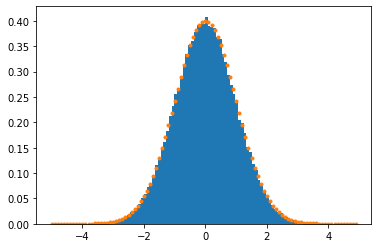

In [ ]:
plt.hist(b,100,density = True)
plt.plot(np.arange(-5,5,0.1),c,'.')
plt.show()

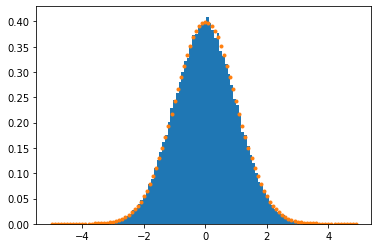

In [ ]:
plt.hist(a,100,density = True)
plt.plot(np.arange(-5,5,0.1),c,'.')
plt.show()

In [ ]:
np.corrcoef(a,b)

array([[ 1.        , -0.00374253],
       [-0.00374253,  1.        ]])

It looks like we do have 2 independant normal.

#  test inverse gamma :


In [ ]:
def dens_inv_gamma(x,a,b):
    from math import gamma
    u = gamma(a)
    return b**a*1/(u)*(1/x)**(a+1) * np.exp(-b/x)

In [ ]:
sigma_1,S1 =5,0.01*5
q = [law.inverse_gamma(sigma_1/2,(S1/2)) for i in range(0,10000)]
b = np.arange(0.0001,5,0.001)
a = [dens_inv_gamma(x,sigma_1/2,(S1/2)) for x in b]

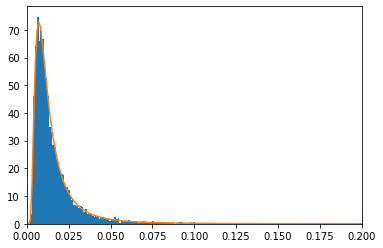

In [ ]:
plt.hist(q,1000, density = True)
plt.plot(b,a)
plt.xlim([0,0.2])
plt.show()

# Gibbs sampler :

## loi à simuler :

### Loi de $\mu$ :

Without prior

$ \pi_{\mu | X_{[0,T]},Y_{[0,T]},\sigma,\phi,X_{-1}} (.|x_{[0,T]},y_{[0,T]},\sigma,\phi,x_{-1}) \sim \mathcal{N}(C,D) $
with $ \begin{cases}
      D = \frac{\sigma^2}{(T+1)(\phi-1)^2} \\
      C = D\frac{(\phi-1)}{\sigma^2} \sum_{t=0}^T (\phi x_{t-1} - x_t)
    \end{cases} $

### Loi de $\sigma$ :

Prior distribution : $ \pi_0(\sigma^2) \sim \mathcal{IG}(\frac{\sigma_1}{2},\frac{S_1}{2}) $

$\pi_{\sigma^2 | X_{[0,T]},Y_{[0,T]},\mu,\phi,X_{-1}} (.|x_{[0,T]},y_{[0,T]},\mu,\phi,x_{-1}) \sim \mathcal{IG}(A,B) $
with $ \begin{cases}
      A = \frac{T+1+\sigma_1}{2} \\
      B = \frac{ \sum_{t=0}^T( (x_{t}-\mu) - \phi(x_{t-1}-\mu))^2}{2}  + \frac{S_1}{2}
 \end{cases} $


### Loi de $\phi$ :

Prior distribution : $ \pi_0(\phi) \sim \mathcal{N}(\mu_\phi,\sigma_\phi) $


$\pi_{\phi | X_{[0,T]},Y_{[0,T]},\mu,\sigma,X_{-1}} (.|x_{[0,T]},y_{[0,T]},\mu,\sigma,x_{-1}) \sim \mathcal{N}(E,F) $
with $ \begin{cases}
      F = ( \sum_{t=0}^T \frac{(x_{t-1} - \mu )^2}{\sigma^2} + \frac{1}{\sigma_\phi^2} )^{-1} \\
      E = F .[ \sum_{t=0}^T \frac{(x_{t}-\mu)(x_{t-1}-\mu)}{\sigma^2}  + \frac{\mu_\phi}{\sigma_\phi^2} ]
 \end{cases} $

### Loi de $X_t$ :

$\forall t \in [1,T-1], \pi_{X_t | X_{-t},Y_{[0,T]},\mu,\sigma,X_{-1},\phi} (k|x_{-t},y_{[0,T]},\mu,\sigma,x_{-1}, \phi) \propto 
\exp{ (\frac{-1}{2\sigma^2}\{ (k-mu)^2(1+\phi^2) - 2\phi(k-\mu)(x_{t-1}+x_{t+1}-2\mu)   \} -\frac{y_t^2}{2e^k} - \frac{x}{2}  ) }$

Ce n'est pas une loi connue

## L'algorithme de Gibbs : 

$\mu^0 = 0 \mbox{ or } \mu^0 \sim \mathcal{N}(0,10) \\
\phi^0 \sim \mathcal{N}(\mu_\phi,\sigma_\phi) \\
\sigma^0 \sim \mathcal{IG}(\frac{\sigma_1}{2},\frac{S_1}{2}) \\
\begin{align}
    X_{[-1,T]} ^0 &= \begin{bmatrix}
           \mu^0 \\
           \mu^0 \\
           \vdots \\
           \mu^0
      \end{bmatrix}
\end{align} $


$ \forall n \in [1,N] :\\
   \qquad X_{-1}^n = \mu^{n-1} \\
   \qquad X_{[0,T]}^n \sim \mbox{Metropolis}(\mu^{n-1},\phi^{n-1},\sigma^{n-1},X_{[0,T]}^{n-1}, Y_{[0,T]}, X_{-1}^n) \\
   \qquad (\sigma^n)^2 \sim \pi_{\sigma^2 | X_{[0,T]},Y_{[0,T]},\mu,\phi,X_{-1}} (.|X_{[0,T]}^n,Y_{[0,T]},\mu^{n-1},\phi^{n-1},X_{-1}^n) \\
   \qquad \sigma^n = \sqrt{(\sigma^n)^2} \\
   \qquad \phi^n \sim \pi_{\phi | X_{[0,T]},Y_{[0,T]},\mu,\sigma,X_{-1}} (.|X_{[0,T]}^n,Y_{[0,T]},\mu^{n-1},\sigma^n,X_{-1}^n) \\
   \qquad \mu^n \sim \pi_{\mu | X_{[0,T]},Y_{[0,T]},\sigma,\phi,X_{-1}} (.|X_{[0,T]}^n,Y_{[0,T]},\sigma^n,\phi^n,X_{-1}^n)$

## L'algorithme de Metropolis :

La loi invariante de $X_t$ n'étant pas connue, on va utiliser un algo de Metropolis pour la simuler :

Pour cela on se sert du fait que :
$ X_t | X_{-t},\phi,\mu,\sigma \sim \mathcal{N}(\mu + \phi(X_{t-1} - \mu), (\sigma)^2) \mbox{ indépdendant de la simulation précédente de } X_t$

Notons $f_{X_t | X_{t-1},\phi,\mu,\sigma} (. | X_{t-1},\phi,\mu,\sigma)$  sa densité.




$\forall n \in [1,N], \mbox{Metropolis}(\mu^{n-1},\phi^{n-1},\sigma^{n-1},X_{[0,T]}^{n-1}, Y_{[0,T]}, X_{-1}^n)$


$ \forall k \in nbsimu : \\
xsimu = X_{t}^{n-1} \\
\forall t \in [1,T-1] : \\
\qquad X_{new} \sim \mathcal{N}(\mu^{n-1} + \phi^{n-1}(X_{t-1}^n - \mu^{n-1}), (\sigma^{n-1})^2) \\
\qquad U \sim \mathcal{U}(0,1) \\
\qquad r = \frac { \pi_{X_t | X_{-t},Y_{[0,T]},\mu,\sigma,X_{-1}, \phi} (X_{new}|(X_{[0,t-1]}^n,X_{[t+1,T]}^{n-1}),Y_{[0,T]},\mu^{n-1},\sigma^{n-1},x_{-1}^{n}, \phi^{n-1}) } { \pi_{Xsimu | X_{-t},Y_{[0,T]},\mu,\sigma,X_{-1}, \phi} (Xsimu|(X_{[0,t-1]}^n,X_{[t+1,T]}^{n-1}),Y_{[0,T]},\mu^{n-1},\sigma^{n-1},x_{-1}^{n},\phi^{n-1})} . 
\frac{f_{X_{t} | X_{t-1},\phi,\mu,\sigma} (Xsimu | X_{t-1}^n,\phi^{n-1},\mu^{n-1},\sigma^{n-1})}{f_{X_t | X_{t-1},\phi,\mu,\sigma} (X_{new} | X_{t-1}^n,\phi^{n-1},\mu^{n-1},\sigma^{n-1})} \\
\qquad Si \space U < min(1,r) : \\
\qquad \qquad xsimu = X_{new} \\
\qquad Sinon : \\
\qquad \qquad xsimu = xsimu \\
X_t^n = xsimu$ 



## L'algorithme d'acceptation rejet

Un autre moyen de simuler Xt est d'utiliser un algorithme d'acceptation rejet.
D'après Kim & Al. 1998

On utilise le fait que $\forall t \in [1,T-1], \pi_{X_t | X_{-t},Y_{[0,T]},\mu,\sigma,X_{-1}} (k|x_{-t},y_{[0,T]},\mu,\sigma,x_{-1}) \propto 
\exp{ (\frac{-1}{2\sigma^2}\{ (k-mu)^2(1+\phi^2) - 2\phi(k-\mu)(x_{t-1}+x_{t+1}-2\mu)   \})}\exp{( -\frac{y_t^2}{2e^k} - \frac{x}{2}  ) } \propto f_{X_t | X_{-t},\mu,\sigma,X_{-1}}(k |x_{-t},\mu,\sigma,x_{-1}) )  f_{Y_t | X_{-t},X_t,\mu,\sigma,X_{-1}}(y_t | x_{-t},k,y_{[0,T]},\mu,\sigma,x_{-1}))$

On va donc supposer pouvoir tirer $X_t \sim f_{X_t | X_{-t},\mu,\sigma,X_{-1}, \phi}(k |x_{-t},\mu,\sigma,x_{-1}, \phi) )$ et utiliser l'acceptation rejet. Or $f_{X_t | X_{-t},\mu,\sigma,X_{-1}, \phi}(k |x_{-t},\mu,\sigma,x_{-1}, \phi) ) \propto \exp(-\frac{(k-G)^2}{2\eta^2})$ avec 
$\begin{cases}
      \eta = \sqrt{\frac{\sigma^2}{1+\phi^2}} \\
      G_t = \mu + \frac{\phi(x_{t-1}+x_{t+1}-2\mu)}{1+\phi^2}
 \end{cases} $.

On va commencer par chercher une densité qui domine $ \pi_{X_t | X_{-t},Y_{[0,T]},\mu,\sigma,X_{-1}} (k|x_{-t},y_{[0,T]},\mu,\sigma,x_{-1})$

On à $ \log(f_{Y_t | X_{-t},X_t,\mu,\sigma,X_{-1}}(y_t | x_{-t},k,y_{[0,T]},\mu,\sigma,x_{-1})) = -\frac{k}{2} -\frac{y_t^2}{2\exp(k)} \leq -\frac{k}{2} -\frac{y_t^2}{2}( \exp(-G_t)(1+G_t) - k\exp(-G_t) ) = \log(g(y_t,k,G_t, \mu,\phi,\sigma))$

donc on a va faire l'algorithme suivant :

$\forall t \in [1,T-1] : \\
\qquad X_t^n = 0 \\
\qquad \mbox{ tant que} X_t^n = 0 \mbox{ et } i<iter :\\
\qquad \qquad X_{new} \sim \mathcal{N}(G_t + \frac{\eta^2}{2}(y_t^2\exp(-G_t)-1), \eta^2) \\
\qquad \qquad U \sim \mathcal{U}(0,1) \\
\qquad \qquad \mbox{ Si } U< \frac{f_{Y_t | X_{-t},X_t,\mu,\sigma,X_{-1}}(y_t | x_{-t},X_{new},y_{[0,T]},\mu,\sigma,x_{-1})}{g(y_t,X_{new},G_t, \mu,\phi,\sigma)} : \\
\qquad \qquad \qquad X_t^n = X_{new} \\
\qquad \qquad i = i+1 \\
\qquad \mbox{ si } X_t^n = 0 : \\
\qquad \qquad X_t^n = X_t^{n-1}$ 


In [ ]:
from tqdm import tqdm 
def Gibbs_sampler(Y,random_seed,N, init,hyperparams, func ):
    
    T = len(Y)-1
    
    sigma_1, S1, sigma_theta,mu_theta = hyperparams
    
    if init == None :
        N1,N2 = law.normal()
        theta0 = N1*sigma_theta + mu_theta
        mu0 = N2*np.sqrt(10) 
        sigma0 = np.sqrt(law.inverse_gamma(sigma_1/2,S1/2))
    else :
        theta0,mu0,sigma0 = init
    
    theta = np.zeros(N+1) 
    theta[0] = theta0
    mu = np.zeros(N+1) 
    mu[0] = mu0
    sigma = np.zeros(N+1) 
    sigma[0] = sigma0
    
    
    X = np.zeros((T+2,N+1)) #each time X[:,i][0] is the X-1
    X[:,0] = np.array([mu0 for i in range(T+2)])
    for i in tqdm(range(N)):
        N1,N2 = law.normal()
        
        #selection de Xi
        Xi = X[:,i+1]
        Xi[0] = mu[i]
        #MAJ de XtXt,mu,sigma,theta,Y, Xt_1
        Xi[1:T+2] = func(Xi,mu[i],sigma[i],theta[i],Y, X[:,i])
    
        X[:,i+1] = Xi
    
        #Update de Sigma -----sigma, problème sur la loi.... inverse gamma semble pas marcher comme elle le devrait....
        #On a des résultats cohérents, mais uniquement avec une loi qui ne devrait pas l'être...
        
        #sigma[i+1] = np.sqrt(1/np.random.gamma((T+1+sigma_1)/2,1/(sum(((Xi[1:T+2]-mu[i]) - theta[i]*(Xi[0:T+1]-mu[i]))**2)/2+S1/2)))
        sigma[i+1] = np.sqrt(law.inverse_gamma((T+1+sigma_1)/2,sum(((Xi[1:T+2]-mu[i]) - theta[i]*(Xi[0:T+1]-mu[i]))**2)/2+S1/2))
        
        ## Update de theta, il y a surement un problème ici...
        B = 1/( sum((Xi[0:T+1]-mu[i])**2) /(sigma[i+1])**2 + 1/(sigma_theta)**2)
        A = B * ( sum((Xi[0:T+1]-mu[i])*(Xi[1:T+2]-mu[i]))/(sigma[i+1])**2 + mu_theta/(sigma_theta)**2)
        
        #theta_new = A + np.sqrt(B)*N1
        theta[i+1] = truncnorm.rvs(-1, 1, loc = A, scale = np.sqrt(B), size=1) [0]
        #if abs(theta_new)>= 1:
        #    theta[i+1] = theta[i]
        #else :
        #    theta[i+1] = theta_new
        
        #update de mu
        
        C = sigma[i+1]**2/((T+1)*(theta[i+1]-1)**2)
        #D = C*(theta[i+1]-1)/sigma[i+1]**2 * sum((theta[i+1] * Xi[0:T+1] - Xi[1:T+2])) 
        D = C*(theta[i+1]-1)/sigma[i+1]**2 * ( sum((theta[i+1] * Xi[1:T+1] - Xi[2:T+2])) +Xi[1])
        #print(D)
        mu[i+1] = D + np.sqrt(C)*N2
        
    return(mu,theta,sigma,X)

## Simulation de Y et Xt

In [ ]:
def Y_X(T,mu0,sigma0,theta0):
    
    X=np.zeros(T+2)
    Y = np.zeros(T+1)
    X[0] = mu0
    for t in range(1,T+2) :
        N1,N2 = law.normal()
        X[t] = N1*sigma0 + mu0 + theta0*(X[t-1]-mu0)
        Y[t-1] = N2*np.sqrt(np.exp(X[t]))
        
    return np.array(Y), np.array(X[1:])

In [ ]:
mu0,sigma0,theta0 = 3,0.1,0.95
T = 100

In [ ]:
Y,X0 = Y_X(T,mu0,sigma0,theta0)

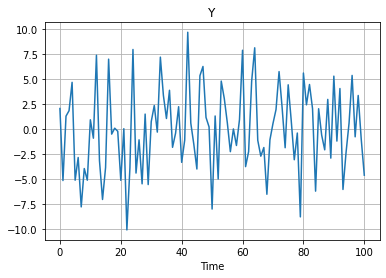

In [ ]:
plt.plot(Y)
plt.grid()
plt.xlabel('Time')
plt.title('Y')
plt.show()

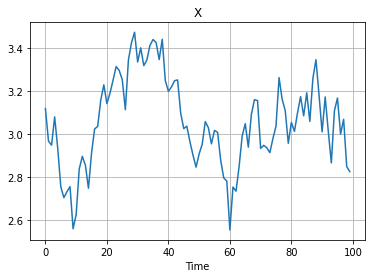

In [ ]:
plt.plot(X0[1:])
plt.grid()
plt.xlabel('Time')
plt.title('X')
plt.show()

## Resultats avec metropolis

In [ ]:
sigma_1, S1, sigma_theta,mu_theta = 5,0.01*5,0.01,theta0
hyperparams = sigma_1, S1, sigma_theta,mu_theta
init = None #theta0,mu0,sigma0
N = 1000
mu,theta,sigma,X = Gibbs_sampler(Y,0,N,init,hyperparams, law.metro_hasting)  #func = law.accptation ou law.metro_hasting

100%|██████████| 1000/1000 [56:58<00:00,  3.42s/it]


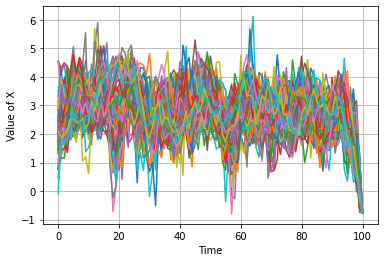

In [ ]:
offset = 100#N//10000
plt.plot(X[1:,-offset:]) #On retire les premier tirage, car il faut un certain temps à l'algorithme pour se lancer...
plt.grid()
plt.ylabel('Value of X')
plt.xlabel('Time')
plt.show()

In [ ]:
m =[]
h = []
l = []
for i in range(1,len(X[:,0])):
    m.append(np.mean(X[i,-offset:]))
    h.append(np.max(X[i,-offset:]))
    l.append(np.min(X[i,-offset:]))

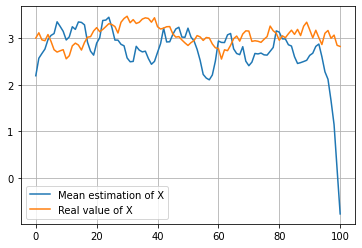

In [ ]:
plt.plot(m, label = 'Mean estimation of X')
plt.plot(X0, label='Real value of X')
#plt.plot(l,'red')
#plt.plot(h,'red')
plt.legend()
plt.grid()
plt.show()

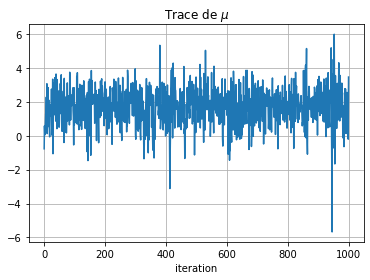

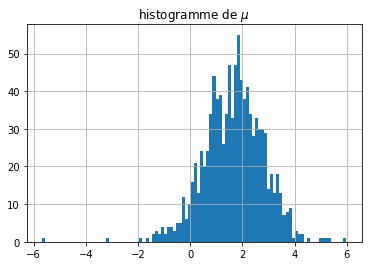

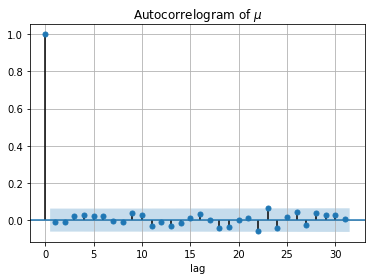

In [ ]:
plt.plot(mu)
plt.grid()
plt.title('Trace de $\mu$')
plt.xlabel('iteration')
plt.show()
plt.hist(mu,100)
plt.title('histogramme de $\mu$')
plt.grid()
plt.show()
plot_acf(mu)
plt.grid()
plt.xlabel('lag')
plt.title('Autocorrelogram of $\mu$')
plt.show()

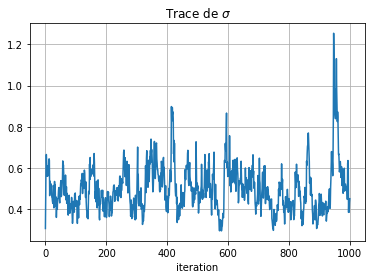

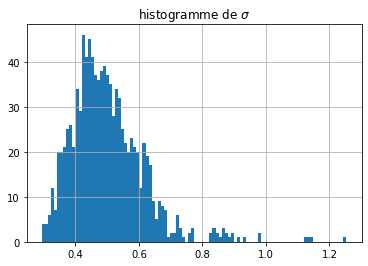

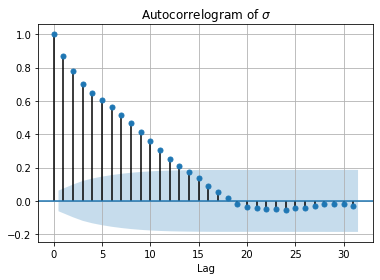

In [ ]:
plt.plot(sigma)
plt.grid()
plt.title('Trace de $\sigma$')
plt.xlabel('iteration')
plt.show()
plt.hist(sigma,100)
plt.title('histogramme de $\sigma$')
plt.grid()
plt.show()
plot_acf(sigma)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\sigma$')
plt.grid()
plt.show()

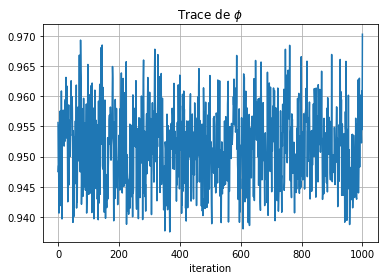

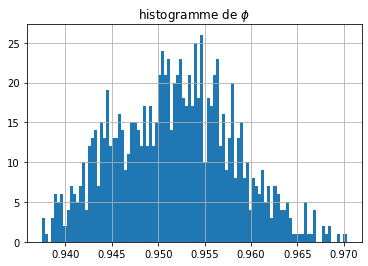

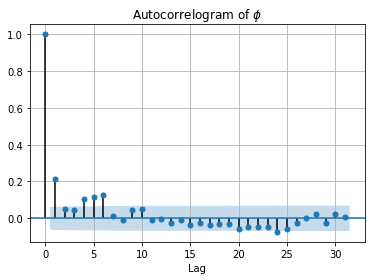

In [ ]:
plt.plot(theta)
plt.grid()
plt.title('Trace de $\phi$')
plt.xlabel('iteration')
plt.show()
plt.hist(theta,100)
plt.title('histogramme de $\phi$')
plt.grid()
plt.show()
plot_acf(theta)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\phi$')
plt.grid()
plt.show()

In [ ]:
print('sigma as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(sigma),np.std(sigma)))
print('mu as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(mu),np.std(mu)))
print('phi as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(theta),np.std(theta)))

sigma as a mean of : 0.500 and a std of 0.114
mu as a mean of : 1.668 and a std of 1.135
phi as a mean of : 0.952 and a std of 0.006


## Resultats avec acceptation-rejet

In [ ]:
sigma_1, S1, sigma_theta,mu_theta = 5,0.01*5,0.01,theta0
hyperparams = sigma_1, S1, sigma_theta,mu_theta
init = None #theta0,mu0,sigma0
N = 5000
mu,theta,sigma,X = Gibbs_sampler(Y,0,N,init,hyperparams, law.accption)  #func = law.accption ou law.metro_hasting

100%|██████████| 5000/5000 [00:21<00:00, 230.63it/s]


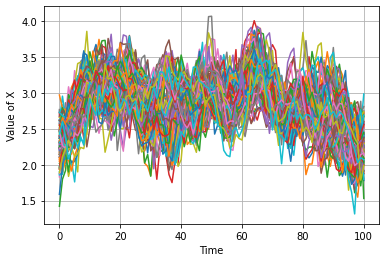

In [ ]:
offset = 100#N//10000
plt.plot(X[1:,-offset:]) #On retire les premier tirage, car il faut un certain temps à l'algorithme pour se lancer...
plt.grid()
plt.ylabel('Value of X')
plt.xlabel('Time')
plt.show()

In [ ]:
m =[]
h = []
l = []
for i in range(1,len(X[:,0])):
    m.append(np.mean(X[i,-offset:]))
    h.append(np.max(X[i,-offset:]))
    l.append(np.min(X[i,-offset:]))

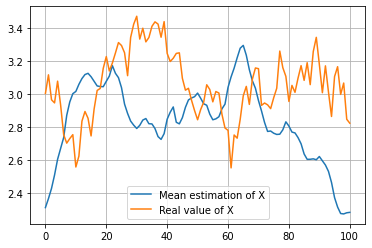

In [ ]:
plt.plot(m, label = 'Mean estimation of X')
plt.plot(X0, label='Real value of X')
#plt.plot(l,'red')
#plt.plot(h,'red')
plt.legend()
plt.grid()
plt.show()

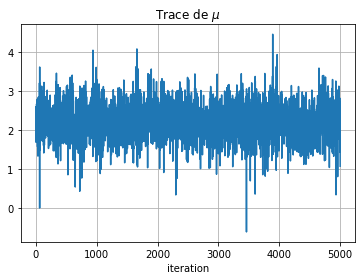

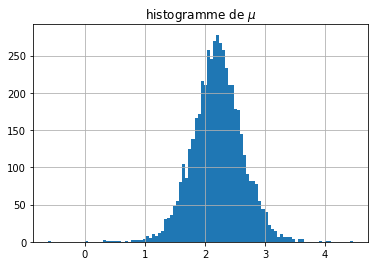

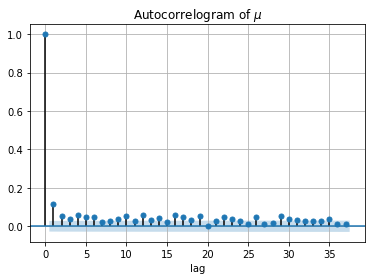

In [ ]:
plt.plot(mu)
plt.grid()
plt.title('Trace de $\mu$')
plt.xlabel('iteration')
plt.show()
plt.hist(mu,100)
plt.title('histogramme de $\mu$')
plt.grid()
plt.show()
plot_acf(mu)
plt.grid()
plt.xlabel('lag')
plt.title('Autocorrelogram of $\mu$')
plt.show()

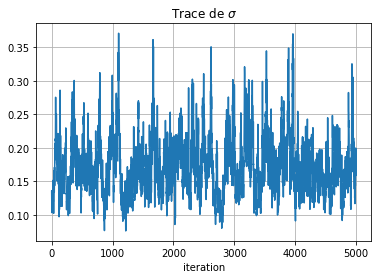

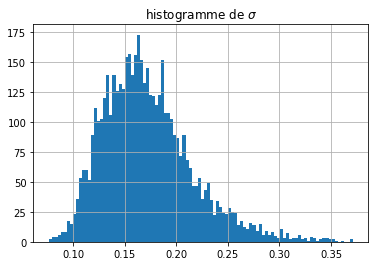

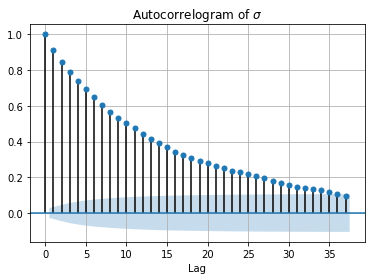

In [ ]:
plt.plot(sigma)
plt.grid()
plt.title('Trace de $\sigma$')
plt.xlabel('iteration')
plt.show()
plt.hist(sigma,100)
plt.title('histogramme de $\sigma$')
plt.grid()
plt.show()
plot_acf(sigma)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\sigma$')
plt.grid()
plt.show()

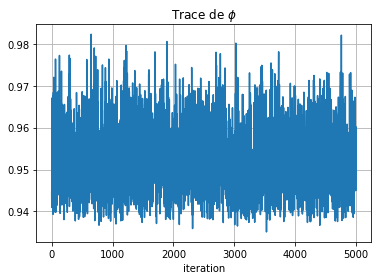

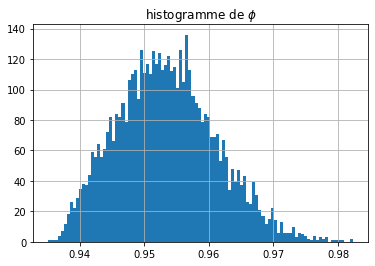

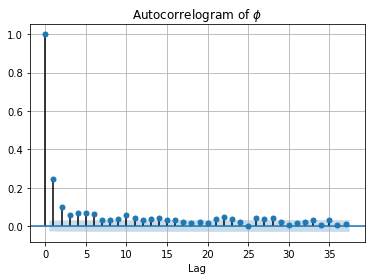

In [ ]:
plt.plot(theta)
plt.grid()
plt.title('Trace de $\phi$')
plt.xlabel('iteration')
plt.show()
plt.hist(theta,100)
plt.title('histogramme de $\phi$')
plt.grid()
plt.show()
plot_acf(theta)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\phi$')
plt.grid()
plt.show()

In [ ]:
print('sigma as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(sigma),np.std(sigma)))
print('mu as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(mu),np.std(mu)))
print('phi as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(theta),np.std(theta)))

sigma as a mean of : 0.172 and a std of 0.044
mu as a mean of : 2.209 and a std of 0.417
phi as a mean of : 0.953 and a std of 0.008


# Test question 4

In [34]:
!pip install yfinance
import yfinance as yf

vix = yf.Ticker("^VIX")
dfvix = vix.history(period="max")

  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [35]:
sp = yf.Ticker("^GSPC")
dfsp = sp.history(period="max")

In [36]:
y = np.log(dfsp[9300:9600].Close.to_list())
y = np.array(y[1:] - y[:len(y)-1])

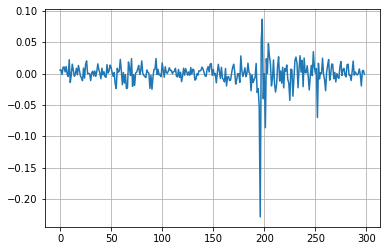

In [37]:
plt.plot(y)
plt.grid()
plt.show()

In [38]:
sigma_1, S1, sigma_theta,mu_theta = 5,0.01*5,0.01,0.95
hyperparams = sigma_1, S1, sigma_theta,mu_theta
init = None #theta0,mu0,sigma0
N = 5000
mu,theta,sigma,X = Gibbs_sampler(y,0,N,init,hyperparams, law.accption)

100%|██████████| 5000/5000 [01:15<00:00, 65.91it/s]


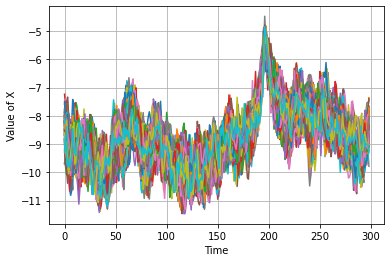

In [39]:
offset = 100#N//10000
plt.plot(X[1:,-offset:]) #On retire les premier tirage, car il faut un certain temps à l'algorithme pour se lancer...
plt.grid()
plt.ylabel('Value of X')
plt.xlabel('Time')
plt.show()

In [40]:
m =[]
h = []
l = []
for i in range(1,len(X[:,0])):
    m.append(np.mean(X[i,-offset:]))
    h.append(np.max(X[i,-offset:]))
    l.append(np.min(X[i,-offset:]))

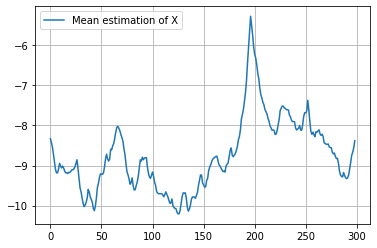

In [41]:
Xvix = dfvix[9500:10000].Close.to_list()
plt.plot(m, label = 'Mean estimation of X')
#plt.plot(Xvix, label='Real value of X')
#plt.plot(l,'red')
#plt.plot(h,'red')
plt.legend()
plt.grid()
plt.show()

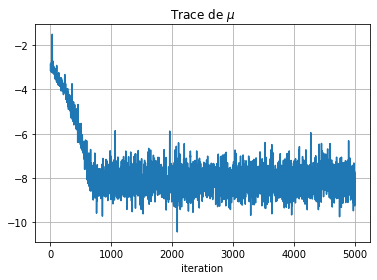

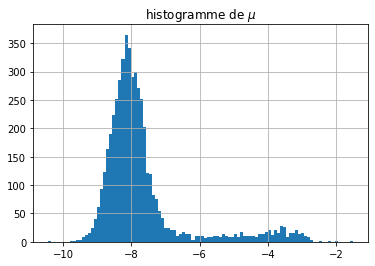

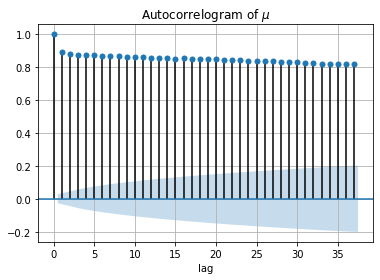

In [42]:
plt.plot(mu)
plt.grid()
plt.title('Trace de $\mu$')
plt.xlabel('iteration')
plt.show()
plt.hist(mu,100)
plt.title('histogramme de $\mu$')
plt.grid()
plt.show()
plot_acf(mu)
plt.grid()
plt.xlabel('lag')
plt.title('Autocorrelogram of $\mu$')
plt.show()

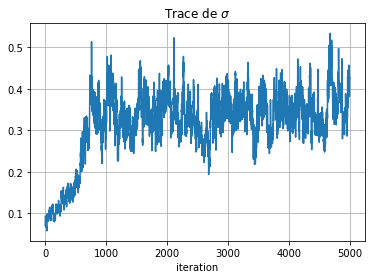

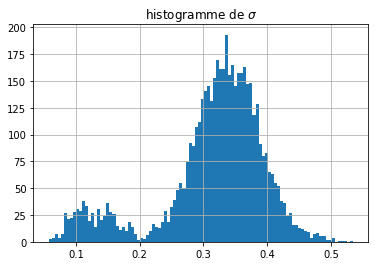

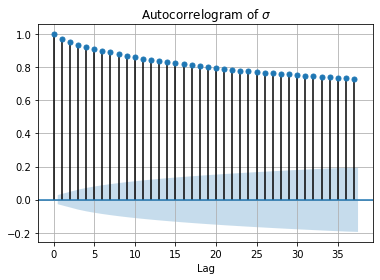

In [43]:
plt.plot(sigma)
plt.grid()
plt.title('Trace de $\sigma$')
plt.xlabel('iteration')
plt.show()
plt.hist(sigma,100)
plt.title('histogramme de $\sigma$')
plt.grid()
plt.show()
plot_acf(sigma)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\sigma$')
plt.grid()
plt.show()

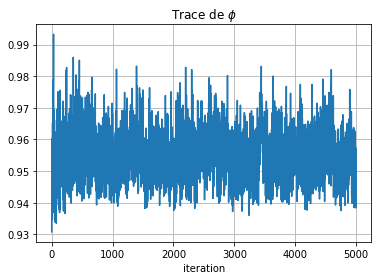

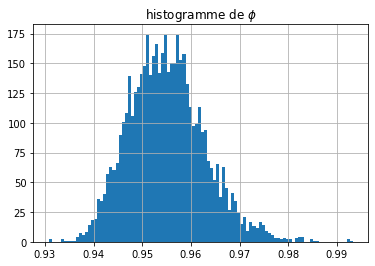

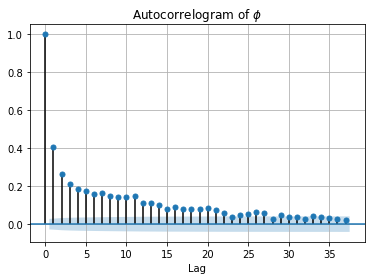

In [44]:
plt.plot(theta)
plt.grid()
plt.title('Trace de $\phi$')
plt.xlabel('iteration')
plt.show()
plt.hist(theta,100)
plt.title('histogramme de $\phi$')
plt.grid()
plt.show()
plot_acf(theta)
plt.xlabel('Lag')
plt.title('Autocorrelogram of $\phi$')
plt.grid()
plt.show()

In [45]:
print('sigma as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(sigma),np.std(sigma)))
print('mu as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(mu),np.std(mu)))
print('phi as a mean of : {0:.3f} and a std of {1:.3f}'.format(np.mean(theta),np.std(theta)))

sigma as a mean of : 0.316 and a std of 0.083
mu as a mean of : -7.689 and a std of 1.286
phi as a mean of : 0.955 and a std of 0.008
